# Bidirectional Exchange Flux Scheme in Surface and Subsurface (BE3S)

In [1]:
import import_ipynb

In [2]:
## BE3S Modules
import SoilWaterFlow as inf
import GroundWaterFlow as wtd
import ChannelFlow as chf
import DistanceMap as dis
import Conversion as conv

importing Jupyter notebook from SoilWaterFlow.ipynb
importing Jupyter notebook from Solver.ipynb
importing Jupyter notebook from Conversion.ipynb
importing Jupyter notebook from DataRead.ipynb
importing Jupyter notebook from DistanceMap.ipynb
importing Jupyter notebook from SpatialDiscretization.ipynb
importing Jupyter notebook from GroundWaterFlow.ipynb
importing Jupyter notebook from ChannelFlow.ipynb


In [3]:
## Internal Modules
import numpy as np
import math as mt
import pandas as pd
import time
from matplotlib import cm
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)

### Recession Analysis

Delaware (simulation length includes travel time)

RE1 (b=3.0) 228 hr

RE2 (b=2.5) 101 hr

RE3 (b=2.0) 113 hr

RE4 (b=1.5) 111 hr

In [4]:
simulationLength = int(input("\nNr of simulation hours:"))    


Nr of simulation hours:228


In [5]:
RE = float(input("\nRE :"))


RE :1


In [6]:
Alpha = float(input("\nFraction of stream-feeding aquifer (-):"))


Fraction of stream-feeding aquifer (-):0.006


In [7]:
WT_initial = float(input("\nInitial saturated aquifer thickness (m):"))


Initial saturated aquifer thickness (m):1.45


In [8]:
SoilGrid_height = int(input("\nThe height of a soil grid (m):"))


The height of a soil grid (m):5


In [9]:
## Initializing degree of saturation
myStr = "Initial degree of saturation (0-1]: " 
Se_init = conv.NODATA
print()
while ((Se_init <= 0.0) or (Se_init > 1.0)):
    Se_init = float(input(myStr)) 


Initial degree of saturation (0-1]: 0.5


In [10]:
## Global variable declaration
maxDistance = np.zeros(len(dis.Chan_indi))
cat_x = np.zeros(dis.ncol * dis.nrow)
cat_y = np.zeros(dis.ncol * dis.nrow)
chan_x = np.zeros(dis.ncol * dis.nrow)
chan_y = np.zeros(dis.ncol * dis.nrow)

## Exchange fluxes variables
Infilt = np.zeros((len(dis.Cat_indi), int(max(dis.Cat_grid_num)), simulationLength))
DPerc = np.zeros((len(dis.Cat_indi), int(max(dis.Cat_grid_num)), simulationLength))
HEF_by_grid = np.zeros((len(dis.Cat_indi), int(max(dis.Cat_grid_num)), simulationLength))

## Soil moisture variables
SMC_profile = np.zeros((len(dis.Cat_indi), int(max(dis.Cat_grid_num)), simulationLength, int(dis.dem.max())))
SoilLayer_num = np.zeros((len(dis.Cat_indi), int(max(dis.Cat_grid_num))))

## SW-GW interaction variables
HEF = np.zeros((len(dis.Cat_indi), simulationLength))
Qlat = np.zeros((len(dis.Cat_indi), simulationLength))
Qlat_2Sided = np.zeros((len(dis.Chan_indi), simulationLength))

## GW variables
GWT_init = np.zeros((len(dis.Cat_indi), int(max(dis.Cat_grid_num)), simulationLength))
Time_varying_depth = np.zeros((len(dis.Cat_indi), int(max(dis.Cat_grid_num)), simulationLength))
Averaged_GWT = np.zeros((len(dis.Cat_indi), int(max(dis.cat_maxDistance) + 1))) + WT_initial

## SW variables 
SH_averaged = np.zeros((len(dis.Cat_indi), simulationLength))
SH_most_upstream = np.zeros((len(dis.Cat_indi), simulationLength))
SH_downstream = np.zeros((len(dis.Cat_indi), simulationLength))
# SH_distribution = np.zeros((len(dis.Cat_indi), simulationLength, int(max(dis.Chan_grid_num))))

In [11]:
def Soil_process(Cat, Cat_grid, Channel_id, Catchment_id, maxDistance, hour, WT_head, Se_init, SoilLayer_num):
    
    # Defining time step (24hour-1day) 
    endTime = 3600 
    nt = 1
    dt = endTime / nt 
    
    totalIterationNr = 0.0

    ## Upper boundary condition [J kg^-1]
    ubPotential = inf.airEntryPotential(Soil[0])     
  
    if hour == 0:    
        Time_varying_depth[Cat][Cat_grid][hour] = dis.dem[int(dis.list_cat_x[Cat][Cat_grid])]\
        [int(dis.list_cat_y[Cat][Cat_grid])] - WT_initial
            
    elif hour > 0:       
#         #### Both effects #### 
#         Time_varying_depth[Cat][Cat_grid][hour] = dis.dem[int(dis.list_cat_x[Cat][Cat_grid])][int(dis.list_cat_y[Cat][Cat_grid])]-\
#         WT_head[wtd.mag_factor * int(dis.dist[int(dis.list_cat_x[Cat][Cat_grid])][int(dis.list_cat_y[Cat][Cat_grid])])-1]-\
#         ((DPerc[Cat][Cat_grid][hour-1] / inf.area) / wtd.Ne) 
#         #####################
        #### Fluvial only #### 
        Time_varying_depth[Cat][Cat_grid][hour] = dis.dem[int(dis.list_cat_x[Cat][Cat_grid])][int(dis.list_cat_y[Cat][Cat_grid])]-\
        WT_head[wtd.mag_factor * int(dis.dist[int(dis.list_cat_x[Cat][Cat_grid])][int(dis.list_cat_y[Cat][Cat_grid])])-1]
        ######################
        
        inf.Updating_depth(Cat, Cat_grid, Soil, Time_varying_depth[Cat][Cat_grid][hour], int(SoilLayer_num))    

    time = 0 
    while (time < endTime):
        
        ## Solving Richards equation using FVM
        ## flux unit: m/hr
        success, nrIterations, Upper_flux, Lower_flux\
        = inf.infiltration_by_FVM(Cat, Cat_grid, Soil, dt, inf.LOGARITHMIC, hour, int(SoilLayer_num))
        
        ## Success means: Richards equation converged successfully        
        if success:
            for i in range(int(SoilLayer_num)):
                inf.oldTheta[Cat][Cat_grid][i] = inf.theta[Cat][Cat_grid][i]

            Infilt[Cat][Cat_grid][hour] += Upper_flux
            DPerc[Cat][Cat_grid][hour] += Lower_flux   
            for k in range(1, int(maxDistance)+1):
                if k == int(dis.dist[int(dis.list_cat_x[Cat][Cat_grid])][int(dis.list_cat_y[Cat][Cat_grid])]):
                    SMC_profile[Cat][Cat_grid][hour][:] = inf.theta[Cat][Cat_grid][:]
            time += dt

        else: 
            ## Adaptive time step
            dt = max(dt / 2, 1)
            for i in range(int(SoilLayer_num+2)):
                inf.theta[Cat][Cat_grid][i] = inf.oldTheta[Cat][Cat_grid][i]
                inf.psi[Cat][Cat_grid][i] = inf.waterPotential(Soil[inf.hor[Cat][Cat_grid][i]], inf.theta[Cat][Cat_grid][i])
    
#     print("Cat= %d, Cat_grid= %d, hour= %d, GW_recharge= %.5f, GWL_depth= %.3f, dz= %.5f, GWL_head= %.5f"\
#           % (Cat, Cat_grid, hour, ((DPerc[Cat][Cat_grid][hour-1] / inf.area) / wtd.Ne)\
#              , Time_varying_depth[Cat][Cat_grid][hour], inf.dz[Cat][Cat_grid][int(SoilLayer_num)], (dis.dem[int(dis.list_cat_x[Cat][Cat_grid])][int(dis.list_cat_y[Cat][Cat_grid])]\
#               - Time_varying_depth[Cat][Cat_grid][hour])))

    return DPerc[Cat][Cat_grid][hour], endTime

In [12]:
def SWGW_process(Cat, GWT_init, Averaged_SH, hour, maxDistance, WT_initial, Univ_dt):
    
    WT_head, DistFromRiver, Qlateral = \
    wtd.WT_Dynamics(GWT_init, Averaged_SH, Univ_dt, maxDistance, WT_initial, int(hour)) ## Qlateral: m3/hr
    
    HEF[Cat][hour] = Qlateral[hour] ## HEF unit: m3/hr or m3 (can be considered m3)
    
    GWT_head = np.append(Averaged_SH, np.array(WT_head[:]))

    np.savetxt("Output/result_GWT_%s_%s.txt" % (Cat, hour), GWT_head, delimiter=" ")

    return WT_head, HEF[Cat][hour]

In [13]:
### Averaging out GWT according to the Euclidean distance from a reach
def GWT_initialization(Cat, Soil_Depth):

    Accum_GWT = np.zeros((len(dis.Cat_indi), int(dis.cat_maxDistance[Cat] + 1)))
    Grid_num_atDist = np.zeros((len(dis.Cat_indi), int(dis.cat_maxDistance[Cat] + 1)))
    
    for q in range(0, int(dis.Cat_grid_num[Cat])):
        for v in range(0, int(dis.cat_maxDistance[Cat] + 1)):
            
            if dis.dist[int(dis.list_cat_x[Cat][q])][int(dis.list_cat_y[Cat][q])] == v:
                Accum_GWT[Cat][v] = Accum_GWT[Cat][v] + (dis.dem[int(dis.list_cat_x[Cat][q])][int(dis.list_cat_y[Cat][q])]\
                                                         - Soil_Depth[q])

                Grid_num_atDist[Cat][v] += 1 
                
    for rt in range(1, int(dis.cat_maxDistance[Cat])):
        Averaged_GWT[Cat][rt] = Accum_GWT[Cat][rt] / Grid_num_atDist[Cat][rt]

In [14]:
## Grid-based surface water routing - Looped rating Muskingum-Cunge method
## Has to provide averaged stream height value at catchment-scale 

def River_routing(cat, Qlat, SH_upstream, Chan_length, hour, Univ_dt):

    SH_in, SH_out, SH_profile = chf.LRMC(Qlat, SH_upstream, Chan_length, cat, hour, Univ_dt)
    
    return SH_in, SH_out, SH_profile

In [15]:
start_time = time.time()

## Reading soil properties
isSuccess, Soil = conv.readSoil("Data/soilUniform_SCL.txt")

for hour in range(0, simulationLength):
    if hour == 0:
        
        for cat in range(0, len(dis.Cat_indi)):
  
            for cat_grid in range(0, int(dis.Cat_grid_num[cat])):

                SoilLayer_num[cat][cat_grid] = inf.initialization(cat, cat_grid, Soil, Se_init,\
                                                                  dis.dem[int(dis.list_cat_x[cat][cat_grid])]\
                                   [int(dis.list_cat_y[cat][cat_grid])] - WT_initial, SoilGrid_height)  

                DPerc[cat][cat_grid][hour], Univ_dt = Soil_process(cat, cat_grid,\
                                                                   dis.Chan_indi[0], dis.Cat_indi[cat],\
                                                                   dis.cat_maxDistance[cat], hour, GWT_init,\
                                                                   Se_init, int(SoilLayer_num[cat][cat_grid]))
            
            SH_averaged[cat][hour] = chf.SH_atHW21['River_stage'][1]
#             SH_most_upstream[0, :] = chf.SH_atHW21['River_stage'][0:simulationLength]
            SH_most_upstream[cat, :] = chf.SH_atHW21['River_stage'][0:simulationLength]
            
    elif hour > 0:
        for cat in range(0, len(dis.Cat_indi)):
            
            WT_head, Qlat[cat][hour] = SWGW_process(cat, np.array(Averaged_GWT[cat, :]).tolist(),\
                                                    SH_averaged[cat][hour-1], hour, int(dis.cat_maxDistance[cat]), WT_initial, Univ_dt) 
            
            Qlat_2Sided[0][hour] += Qlat[cat][hour]
            
            for cat_grid in range(0, int(dis.Cat_grid_num[cat])): 
                DPerc[cat][cat_grid][hour], Univ_dt = Soil_process(cat, cat_grid, dis.Chan_indi[0], dis.Cat_indi[cat],\
                                                                    dis.cat_maxDistance[cat], hour, WT_head, Se_init,\
                                                                    SoilLayer_num[cat][cat_grid])  
            
            GWT_initialization(cat, np.array(Time_varying_depth[cat, :, hour]).tolist())
            
            ## Grid-based LRMC routing 
            if (cat > 0):
                SH_in, SH_out, SH_profile = River_routing(0, Qlat_2Sided[0][hour], SH_most_upstream[cat][hour-1],\
                                                              int(dis.Chan_grid_num[0]), hour, Univ_dt)

    #             if cat == 0:
    #                 SH_in, SH_out, SH_profile = River_routing(cat, Qlat[cat][hour], SH_most_upstream[cat][hour-1],\
    #                                                           int(dis.Chan_grid_num[cat]), hour, Univ_dt)
    #             elif cat > 0:
    #                 SH_in, SH_out, SH_profile = River_routing(cat, Qlat[cat][hour], SH_out, int(dis.Chan_grid_num[cat]),\
    #                                                           hour, Univ_dt)
                np.savetxt("Output/result_SH_profile_%s_%s.txt" % (dis.Chan_indi[0], hour), SH_profile, delimiter=" ")           
                SH_averaged[0][hour] = np.average(SH_profile)
                SH_averaged[1][hour] = np.average(SH_profile)

print("---- Execution time: %.1f seconds ----" % (time.time() - start_time))

---- Execution time: 264.1 seconds ----


# LET'S MAKE PLOTS

### SWS, GWS daily mass flux balance

In [16]:
Start_time = 1
End_time = simulationLength

### NSD

No handles with labels found to put in legend.


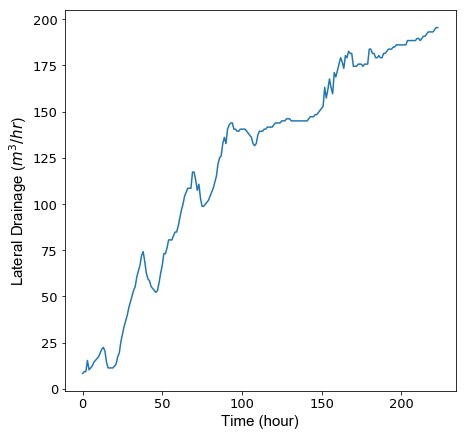

In [17]:
plt.figure(figsize=(7, 7))
axis_font = {'fontname':'Arial', 'size':'15'}

plt.plot(Qlat_2Sided[0][4:End_time])
plt.xlabel("Time (hour)", **axis_font)
plt.ylabel("Lateral Drainage ($m^3/hr$)", **axis_font)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.legend(prop={'size': 13}, frameon = False)
plt.show()

In [18]:
np.savetxt('Output/NSD/NSD_RE%s-R%s_D%s_ZeroBC.txt' % (RE, Alpha, WT_initial), Qlat_2Sided[0][0:End_time])

In [ ]:
GWT_combined_1 = {}
GWT_combined_2 = {}
# GWT_combined_3 = {}
# GWT_combined_4 = {}

NN = simulationLength
for n in range(1, NN):
    GWT_combined_1[n] = pd.read_csv('Output/result_GWT_0_{0}.txt'.format(n))
    GWT_combined_2[n] = pd.read_csv('Output/result_GWT_1_{0}.txt'.format(n))
#     GWT_combined_3[n] = pd.read_csv('Output/result_GWT_2_{0}.txt'.format(n))

(pd.concat([GWT_combined_1[n] for n in range(1, NN)], axis=1)
  .to_csv('Output/Combined_GWL/RE1_Slope3_NSD/GWL_combined_cat1_RE%s-a%s_D%s.txt' % (RE, Alpha, WT_initial), index=False, na_rep='N/A', sep="\t")
)
(pd.concat([GWT_combined_2[n] for n in range(1, NN)], axis=1)
  .to_csv('Output/Combined_GWL/RE1_Slope3_NSD/GWL_combined_cat2_RE%s-a%s_D%s.txt' % (RE, Alpha, WT_initial), index=False, na_rep='N/A', sep="\t")
)

# (pd.concat([GWT_combined_3[n] for n in range(1, NN)], axis=1)
#   .to_csv('Output/Combined_GWL/GWL_combined_A0.01_D7.6_Cat3.txt', index=False, na_rep='N/A', sep="\t")
# )

### Streamflow hydrograph

In [ ]:
from pylab import figure, show, legend, ylabel

title_font = {'fontname':'Arial', 'size':'25', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'}

axis_font = {'fontname':'Arial', 'size':'20'}

## River stage time series
# plt.title("River stage hourly time series", **title_font)
# plt.plot(chf.SH_inlet[0][Start_time:simulationLength-1], 'b-', label="Upstream (1st catchment)")
# plt.plot(chf.SH_outlet[0][Start_time:simulationLength-1], 'r-', label="Downstream (1th catchment)")
# Streamflow time series
plt.plot(chf.Streamflow_profile[0][Start_time:simulationLength] / 3600, 'b-', label="Upstream (1st catchment)")
plt.plot(chf.Streamflow_profile[int(dis.Chan_grid_num)-1][Start_time:simulationLength] / 3600, 'r-', label="Downstream (1th catchment)")

plt.xlabel("Time (hours)", **axis_font)
plt.ylabel("Streamflow ($m^3$)", **axis_font)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15, rotation=0)
plt.legend(prop={'size': 16}, frameon = False)
plt.show()

np.savetxt("Output/Streamflow/RE4/Streamflow_RecessionEvent4_A%s_D%s.txt" % (Alpha, WT_initial), chf.Streamflow_profile[int(dis.Chan_grid_num)-1][Start_time:simulationLength] / 3600, delimiter=" ")

In [ ]:
chf.SH_outlet[0][Start_time:simulationLength]

In [ ]:
from pylab import figure, show, legend, ylabel

title_font = {'fontname':'Arial', 'size':'25', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'}

axis_font = {'fontname':'Arial', 'size':'20'}

## River stage time series
plt.title("River stage hourly time series", **title_font)
plt.plot(chf.SH_inlet[0][Start_time:simulationLength], 'b-', label="Upstream (1st catchment)")
plt.plot(chf.SH_outlet[0][Start_time:simulationLength], 'r-', label="Downstream (1st catchment)")
# Streamflow time series
# plt.plot(chf.Streamflow_profile[0][Start_time:simulationLength-1] / 3600, 'b-', label="Upstream (1st catchment)")
# plt.plot(chf.Streamflow_profile[int(dis.Chan_grid_num)-1][Start_time:simulationLength-1] / 3600, 'r-', label="Downstream (1th catchment)")

plt.xlabel("Time (hours)", **axis_font)
plt.ylabel("Streamflow ($m^3$)", **axis_font)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15, rotation=0)
plt.legend(prop={'size': 16}, frameon = False)
plt.show()

In [ ]:
chf.SH_outlet[0][Start_time+5:simulationLength]
np.savetxt("Output/RA/RS_b1.5_A%s_D%s.txt" % (Alpha, WT_initial), chf.SH_outlet[0][Start_time:simulationLength], delimiter=" ")

In [ ]:
SWS_Initial = np.zeros((len(dis.Cat_indi), int(max(dis.Cat_grid_num))))
SWS_Final = np.zeros((len(dis.Cat_indi), int(max(dis.Cat_grid_num))))
SWS_diff = np.zeros((len(dis.Cat_indi), simulationLength, int(max(dis.Cat_grid_num))))
SWS_state = np.zeros((len(dis.Cat_indi), simulationLength))

GWS_Initial = np.zeros((len(dis.Cat_indi), int(max(dis.Cat_grid_num))))
GWS_Final = np.zeros((len(dis.Cat_indi), int(max(dis.Cat_grid_num))))
GWS_diff = np.zeros((len(dis.Cat_indi), simulationLength, int(max(dis.Cat_grid_num))))

Infilt_Sum = np.zeros((len(dis.Cat_indi), int(max(dis.Cat_grid_num))))
Infilt_Sum0 = np.zeros((len(dis.Cat_indi), int(max(dis.Cat_grid_num))))
DPerc_Sum = np.zeros((len(dis.Cat_indi), int(max(dis.Cat_grid_num))))
DPerc_Sum0 = np.zeros((len(dis.Cat_indi), int(max(dis.Cat_grid_num))))
Qlat_Sum = np.zeros((len(dis.Cat_indi), int(max(dis.Cat_grid_num))))

In [ ]:
Ratio_SWS = np.zeros((len(dis.Cat_indi), simulationLength))
Ratio_GWS = np.zeros((len(dis.Cat_indi), simulationLength))

def Subsurface_MassBal(End_time):
    for cat in range(0, len(dis.Cat_indi)):
        for cat_grid in range(0, int(dis.Cat_grid_num[cat])):         
            SWS_Final[cat][cat_grid] = SMC_profile[cat][cat_grid][End_time][1:1+int(SoilLayer_num[cat, cat_grid])].sum() * \
            (Time_varying_depth[cat, cat_grid, End_time] / SoilLayer_num[cat, cat_grid]) * pow(dis.resolution, 2)
            SWS_Initial[cat][cat_grid] = SMC_profile[cat][cat_grid][End_time-1][1:1+int(SoilLayer_num[cat, cat_grid])].sum() * \
            (Time_varying_depth[cat, cat_grid, End_time-1] / SoilLayer_num[cat, cat_grid]) * pow(dis.resolution, 2)
            
            GWS_Final[cat][cat_grid] = (dis.dem[int(dis.list_cat_x[cat][cat_grid])]\
                                        [int(dis.list_cat_y[cat][cat_grid])]\
                                        - Time_varying_depth[cat, cat_grid, End_time]) * pow(dis.resolution, 2) * (wtd.Ne)
            GWS_Initial[cat][cat_grid] = (dis.dem[int(dis.list_cat_x[cat][cat_grid])]\
                                          [int(dis.list_cat_y[cat][cat_grid])]\
                                          - Time_varying_depth[cat, cat_grid, End_time-1]) * pow(dis.resolution, 2) * (wtd.Ne)

#         SWS_state[cat][End_time] = SWS_Final[cat][cat_grid]
        SWS_state[cat][End_time] = SWS_Final[cat][0:cat_grid].sum()
        SWS_diff[cat][End_time][:] = SWS_Final[cat, :] - SWS_Initial[cat, :]

        FluxBal_SWS = (Infilt[cat, :, End_time] - DPerc[cat, :, End_time]).sum()\
        - (DPerc[cat, :, End_time-1].sum() - Qlat[cat, End_time-1])
        
        MassBal_SWS = FluxBal_SWS - SWS_diff[cat][End_time][:].sum()
        Ratio_SWS[cat][End_time] = 1 / abs(SWS_diff[cat][End_time][:].sum() / FluxBal_SWS) 
        
        if Ratio_SWS[cat][End_time] > 1:
            Ratio_SWS[cat][End_time] = 1 / Ratio_SWS[cat][End_time]

        GWS_diff[cat][End_time][:] = GWS_Final[cat, :] - GWS_Initial[cat, :]
        FluxBal_GWS = (DPerc[cat, :, End_time-1]).sum() - (Qlat[cat, End_time] + Qlat[cat, End_time-1])   
#         FluxBal_GWS = (DPerc[cat, :, End_time-1]).sum() - (Qlat[cat, End_time])   
        
        MassBal_GWS = FluxBal_GWS - GWS_diff[cat][End_time][:].sum()
        Ratio_GWS[cat][End_time] = 1 / abs(GWS_diff[cat][End_time][:].sum() / FluxBal_GWS) 
        if Ratio_GWS[cat][End_time] > 1:
            Ratio_GWS[cat][End_time] = 1 / Ratio_GWS[cat][End_time]

In [ ]:
for i in range(0, End_time):
    Subsurface_MassBal(i)

In [ ]:
plt.figure(figsize=(7, 7), dpi=80)
plt.scatter(Ratio_SWS[0, 90:End_time], Ratio_GWS[0, 90:End_time], c="green", alpha=0.7)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.xlabel('Mass Balance Ratio in Soil (m3/m3)', fontsize = 11)
plt.ylabel('Mass Balance Ratio in Groundwater (m3/m3)', fontsize = 11)
plt.show()

In [ ]:
# np.savetxt("Output/Subsurface/MassBalance/SWS_MBR_SCL_Ks0.002.txt", Ratio_SWS[:, :], delimiter=" ")
# np.savetxt("Output/Subsurface/MassBalance/GWS_MBR_SCL_Ks0.002.txt", Ratio_GWS[:, :], delimiter=" ")

In [ ]:
# MBR_SWS = np.loadtxt("Output/Subsurface/MassBalance/SWS_MBR_Lowflow_BiFlow.txt", delimiter=" ")
# MBR_GWS = np.loadtxt("Output/Subsurface/MassBalance/GWS_MBR_Lowflow_BiFlow.txt", delimiter=" ")

### Mapped SWS, net recharge, and topographyTopography

In [ ]:
Soildepth_averaged = [np.average(SoilLayer_num[std, :]) for std in range(0,1)]
# Soildepth_averaged

In [ ]:
Slope_averaged = [np.max(SoilLayer_num[std, :]) - np.min(SoilLayer_num[std, :]) / dis.cat_maxDistance[std] for std in range(0,1)]
# Slope_averaged

In [ ]:
np.savetxt('Output/Distribution/DP_SiL_Ks0.002.txt', DPerc[0, :, :])

In [ ]:
Net_GWrecharge = [np.sum(DPerc[0, 10, :]) / dis.Cat_grid_num[std] for std in range(0,1)]
Net_GWrecharge

In [ ]:
# [DPerc[0, std, :].sum() for std in range(0, 40)]

In [ ]:
ncol = 21
nrow = 20

DPerc_dist = np.zeros((nrow, ncol)) - 9999
GWS_dist = np.zeros((nrow, ncol)) - 9999
SWS_dist = np.zeros((nrow, ncol)) - 9999
Topo_dist = np.zeros((nrow, ncol)) - 9999

for m in range(0, len(dis.Chan_indi)):
    for n in range(0, int(dis.Cat_grid_num[m])):
        ## Monthly-cumulative net recharge (exchanges between vadose-phreatic zone)
        DPerc_dist[int(dis.list_cat_x[m][n])][int(dis.list_cat_y[m][n])] = float(sum([np.sum(DPerc[m, n, std]\
                        for std in range(1, End_time))])/len([np.sum(DPerc[m, n, std] for std in range(1, End_time))]))
  
        ## monthly-cumulative SWS 
        SWS_temp = [np.cumsum(np.sum(SMC_profile[m, n, std, 2:1+int(SoilLayer_num[m, n])]) * (Time_varying_depth[m, n, std]\
                        / SoilLayer_num[m, n]) * pow(dis.resolution, 2)) for std in range(1, End_time)]
        ## monthly-averaged GWS 
        GWS_temp = [np.cumsum(np.sum(dis.dem[int(dis.list_cat_x[m][n])]\
                    [int(dis.list_cat_y[m][n])] - Time_varying_depth[m, n, std]) * pow(dis.resolution, 2) * (wtd.Ne)) for std in range(1, End_time)]
        
        ## Daily averaged SWS and GWS
        SWS_dist[int(dis.list_cat_x[m][n])][int(dis.list_cat_y[m][n])] = float(sum(SWS_temp) / len(SWS_temp))
        GWS_dist[int(dis.list_cat_x[m][n])][int(dis.list_cat_y[m][n])] = float(sum(GWS_temp) / len(GWS_temp))
        Topo_dist[int(dis.list_cat_x[m][n])][int(dis.list_cat_y[m][n])] = SoilLayer_num[m, n]

In [ ]:
## States
np.savetxt('Output/Distribution/SWS_distribution_SiL_Ks0.002.txt', SWS_dist)
np.savetxt('Output/Distribution/GWS_distribution_SiL_Ks0.002.txt', GWS_dist)
np.savetxt('Output/Distribution/Topo_distribution_SiL_Ks0.002.txt', Topo_dist)

## Fluxes 
np.savetxt('Output/Distribution/DPerc_distribution_SiL_Ks0.002.txt', DPerc_dist)
np.savetxt('Output/Distribution/Qlat_distribution_SiL_Ks0.002.txt', Qlat.transpose())

## Streamflow hydrographs and mass balance in channel
np.savetxt('Output/Distribution/Streamflowoutlet_SiL_Ks0.002.txt', chf.Streamflow_profile[int(dis.Chan_grid_num)-1][0:simulationLength-1])
np.savetxt('Output/Distribution/StreamflowInlet_SiL_Ks0.002.txt', chf.Streamflow_profile[0][0:simulationLength-1])
np.savetxt('Output/Distribution/NSD_distribution_SiL_Ks0.002.txt', chf.Streamflow_profile[int(dis.Chan_grid_num)-1][0:simulationLength-1] -\
            chf.Streamflow_profile[0][0:simulationLength-1])

## Mass balance in channel stream

#### Scatter plot

In [ ]:
# title_font = {'fontname':'Arial', 'size':'25', 'color':'black', 'weight':'normal',
#               'verticalalignment':'bottom'}

# plt.figure(figsize=(7, 7))
# axis_font = {'fontname':'Arial', 'size':'15'}

# plt.scatter(Qlat[0][:simulationLength-1] * 40, chf.Streamflow_profile[int(dis.Chan_grid_num)-1][0:simulationLength-1] -\
#             chf.Streamflow_profile[0][:simulationLength-1], marker='o')

# plt.xlabel("Lateral Drainage ($m^3$)", **axis_font)
# plt.ylabel("Net Subsurface Discharge ($m^3$)", **axis_font)
# plt.xticks(fontsize=13, rotation=0)
# plt.yticks(fontsize=13, rotation=0)
# plt.legend(prop={'size': 13}, frameon = False)
# plt.show()

### Streamflow hydrograph

In [ ]:
from pylab import figure, show, legend, ylabel

Start_time = 1

title_font = {'fontname':'Arial', 'size':'25', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'}

axis_font = {'fontname':'Arial', 'size':'20'}

## River stage time series
# plt.title("River stage hourly time series", **title_font)
# plt.plot(chf.SH_inlet[0][Start_time:simulationLength-1], 'b-', label="Upstream (1st catchment)")
# plt.plot(chf.SH_outlet[0][Start_time:simulationLength-1], 'r-', label="Downstream (1th catchment)")
# Streamflow time series
plt.plot(chf.Streamflow_profile[0][Start_time:simulationLength-1], 'b-', label="Upstream (1st catchment)")
plt.plot(chf.Streamflow_profile[int(dis.Chan_grid_num)-1][Start_time:simulationLength-1], 'r-', label="Downstream (1th catchment)")
## Streamflow difference (outlet-inlet) time series
# plt.title("Streamflow difference hourly time series", **title_font)
# plt.plot(chf.Streamflow_profile[int(dis.Chan_grid_num)-1][Start_time:simulationLength-1] - \
#          chf.Streamflow_profile[0][Start_time:simulationLength-1], 'g-', label="Upstream (1st catchment)")

plt.xlabel("Time (hours)", **axis_font)
plt.ylabel("Streamflow difference ($m^3$)", **axis_font)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15, rotation=0)
plt.legend(prop={'size': 16}, frameon = False)
plt.show()

## Head distribution of groundwater and river

In [ ]:
def Spatial_ascii(tt):

    filename = 'Output/result_SH_profile_101_{0}.txt'.format(tt)

    SH_0 = np.loadtxt(filename, delimiter='\n')
    
    ncol = 21
    nrow = 20
    GWT_dist = np.zeros((nrow, ncol)) - 9999
    
    ## Making snapshot at time step tt (day)
    for m in range(0, len(dis.Chan_indi)):
        if m == 0:
            for n in range(0, int(dis.Cat_grid_num[m])):
                GWT_dist[int(dis.list_cat_x[m][n])][int(dis.list_cat_y[m][n])] = (dis.dem[int(dis.list_cat_x[m][n])][int(dis.list_cat_y[m][n])]\
              - Time_varying_depth[m][n][tt])
            for nn in range(0, int(dis.Chan_grid_num[m])):
                GWT_dist[int(dis.list_chan_x[m][nn])][int(dis.list_chan_y[m][nn])] = SH_0[nn]
                
    np.savetxt('Output/Ascii/Head_distribution_at_{0}hour.txt'.format(tt), GWT_dist)

In [ ]:
for n in range(6, 9):
    Spatial_ascii(n)

## GWL combined file

In [ ]:
# GWT_combined_1 = {}
# # GWT_combined_2 = {}
# # GWT_combined_3 = {}
# # GWT_combined_4 = {}

# NN = simulationLength
# for n in range(1, NN):
#     GWT_combined_1[n] = pd.read_csv('Output/result_GWT_0_{0}.txt'.format(n))
# #     GWT_combined_2[n] = pd.read_csv('Output/result_GWT_1_{0}.txt'.format(n))
# #     GWT_combined_3[n] = pd.read_csv('Output/result_GWT_2_{0}.txt'.format(n))
# #     GWT_combined_4[n] = pd.read_csv('Output/result_GWT_3_{0}.txt'.format(n))

# (pd.concat([GWT_combined_1[n] for n in range(1, NN)], axis=1)
#   .to_csv('Output/Combined_GWL/GWL_combined_Recession3_A0.01_D6.txt', index=False, na_rep='N/A', sep="\t")
# )
# # (pd.concat([GWT_combined_2[n] for n in range(1, NN)], axis=1)
# #   .to_csv('Output/Combined_GWL/GWL_combined.txt', index=False, na_rep='N/A', sep="\t")
# # )
# # (pd.concat([GWT_combined_3[n] for n in range(1, NN)], axis=1)
# #   .to_csv('Output/Combined_GWL/GWL_combined_A0.01_D7.6_Cat3.txt', index=False, na_rep='N/A', sep="\t")
# # )
# # (pd.concat([GWT_combined_4[n] for n in range(1, NN)], axis=1)
# #   .to_csv('Output/Combined_GWL/GWL_combined.txt', index=False, na_rep='N/A', sep="\t")
# # )

In [ ]:
# (pd.concat([GWT_combined_1[n] for n in range(1, NN)], axis=1)
#   .to_csv('Output/Combined_GWL/GWL_combined_Recession3_A0.01_D6.txt', index=False, na_rep='N/A', sep="\t")
# )
# # (pd.concat([GWT_combined_2[n] for n in range(1, NN)], axis=1)
# #   .to_csv('Output/Combined_GWL/GWL_combined.txt', index=False, na_rep='N/A', sep="\t")
# # )
# # (pd.concat([GWT_combined_3[n] for n in range(1, NN)], axis=1)
# #   .to_csv('Output/Combined_GWL/GWL_combined_A0.01_D7.6_Cat3.txt', index=False, na_rep='N/A', sep="\t")
# # )
# # (pd.concat([GWT_combined_4[n] for n in range(1, NN)], axis=1)
# #   .to_csv('Output/Combined_GWL/GWL_combined.txt', index=False, na_rep='N/A', sep="\t")
# # )